## Loading cell positions and colors from whole worm data

In [1]:
import csv

%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['legend.handlelength'] = 0
plt.rcParams["figure.figsize"] = (16,3)

def translate_pal_color(r_z,g_z,b_z):
    # Very, very, very approximately!
    def z_to_0_1(z):
        return min(1,max(0,(z)/5.))
    rgb = (z_to_0_1(r_z),z_to_0_1(g_z),z_to_0_1(b_z))
    #print('Converted expression (%s,%s,%s) to %s'%(r_z,g_z,b_z,rgb))
    return rgb

saved_colors = {}
def load_positions(csv_file):
    positions = {}
    file_name = csv_file.split('/')[-1]
    if not file_name in saved_colors:
        saved_colors[file_name] = {}

    with open(csv_file, newline='') as csvfile:
        linereader = csv.reader(csvfile, delimiter=',')
        for row in linereader:
            index_id = 1 if len(row)==5 else 0
            index_x = 2 if len(row)==5 else 1
            index_y = 3 if len(row)==5 else 2
            index_z = 4 if len(row)==5 else 3
            cell_name = row[index_id]
            #print(cell_name)
            
            if cell_name != 'User ID':
                positions[cell_name] = {}
                positions[cell_name]['ap_position'] = float(row[index_x])
                positions[cell_name]['dv_position'] = float(row[index_y])
                positions[cell_name]['lr_position'] = float(row[index_z])

                positions[cell_name]['color'] = 'b'
                if len(row)>5:
                    positions[cell_name]['color'] = translate_pal_color(float(row[5]),
                                                                        float(row[6]),
                                                                        float(row[7]))
                    saved_colors[file_name][cell_name] = positions[cell_name]['color']
                elif cell_name in saved_colors[file_name]:
                    positions[cell_name]['color'] = saved_colors[file_name][cell_name]

    print('Loaded in %i positions from %s'%(len(positions),csv_file))
    return positions

In [2]:

def generate_ap_dv_plot(positions, ref, type):

    plt.figure()
    plt.title('AP-DV - %s (%s.csv)'%(type, ref))
    plt.axis('equal')

    for neuron in sorted(positions.keys()):
    
        label='%s'%neuron
        plt.plot(positions[neuron]['ap_position'], 
                 positions[neuron]['dv_position'], 
                 marker="o",
                 linestyle=None,
                 color=positions[neuron]['color'],
                 label=label)
        
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=15)

def generate_ap_lr_plot(positions, ref, type):
        
    plt.figure()
    plt.title('AP-LR - %s (%s.csv)'%(type, ref))
    plt.axis('equal')

    for neuron in positions:

        label=None
        plt.plot(positions[neuron]['ap_position'], 
                 positions[neuron]['lr_position'], 
                 marker="o",
                 linestyle=None,
                 color=positions[neuron]['color'],
                 label=label)

Loaded in 300 positions from data/WholeWorm/atlas.csv


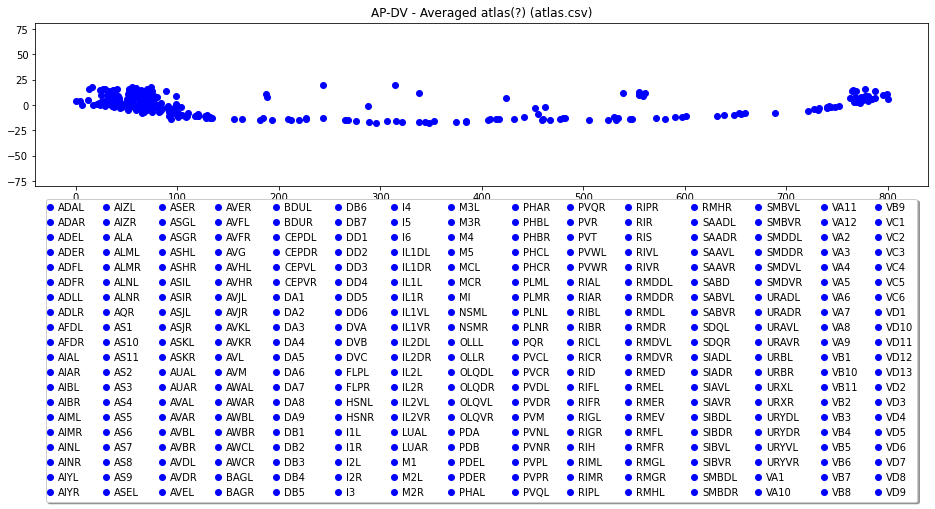

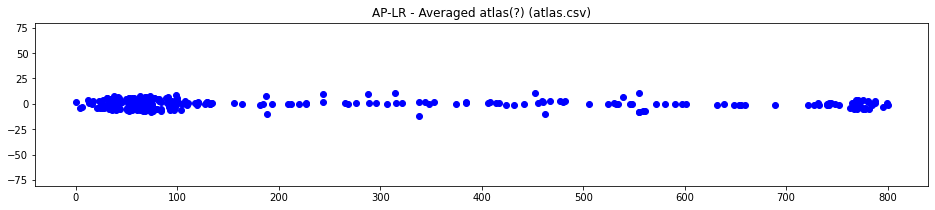

In [3]:
positions = load_positions('data/WholeWorm/atlas.csv')
generate_ap_dv_plot(positions, 'atlas', 'Averaged atlas(?)')
generate_ap_lr_plot(positions, 'atlas', 'Averaged atlas(?)')

{'1_YAw': 'young-adult hermaphrodite', '2_AMw': 'adult male', '3_NPv16-64_YAw': 'young-adult hermaphrodite', '7_YAw': 'young-adult hermaphrodite', '9_YAw': 'young-adult hermaphrodite', '14_Aw': 'adult hermaphrodite', '24_L4w': 'L4 larval stage'}
Loaded in 238 positions from data/WholeWorm/Raw Unstraightened Individuals with colors/1_YAw.csv
Loaded in 218 positions from data/WholeWorm/Raw Unstraightened Individuals with colors/2_AMw.csv
Loaded in 265 positions from data/WholeWorm/Raw Unstraightened Individuals with colors/3_NPv16-64_YAw.csv
Loaded in 231 positions from data/WholeWorm/Raw Unstraightened Individuals with colors/7_YAw.csv
Loaded in 227 positions from data/WholeWorm/Raw Unstraightened Individuals with colors/9_YAw.csv
Loaded in 249 positions from data/WholeWorm/Raw Unstraightened Individuals with colors/14_Aw.csv
Loaded in 236 positions from data/WholeWorm/Raw Unstraightened Individuals with colors/24_L4w.csv


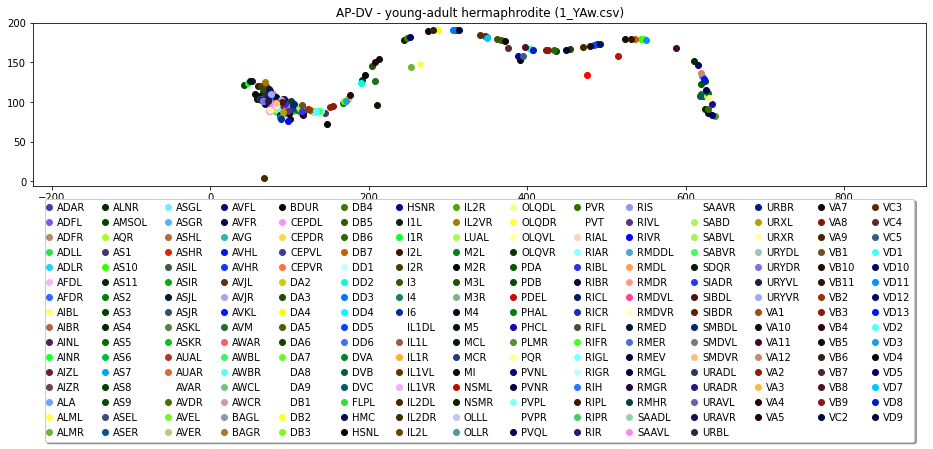

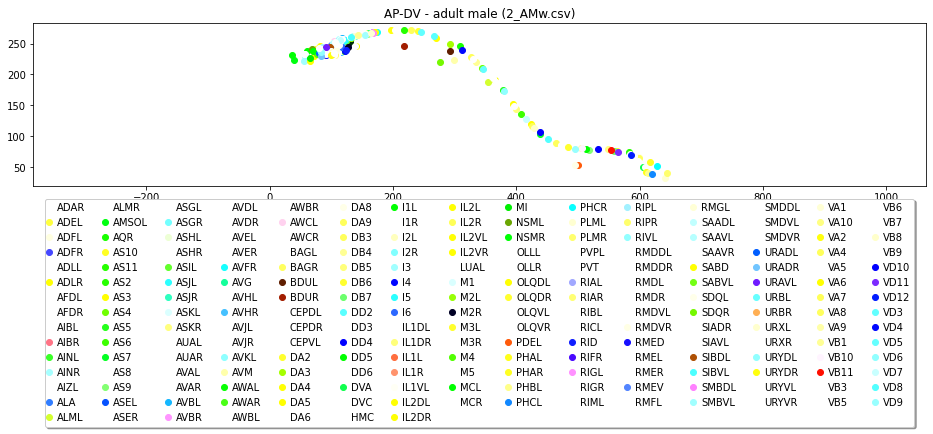

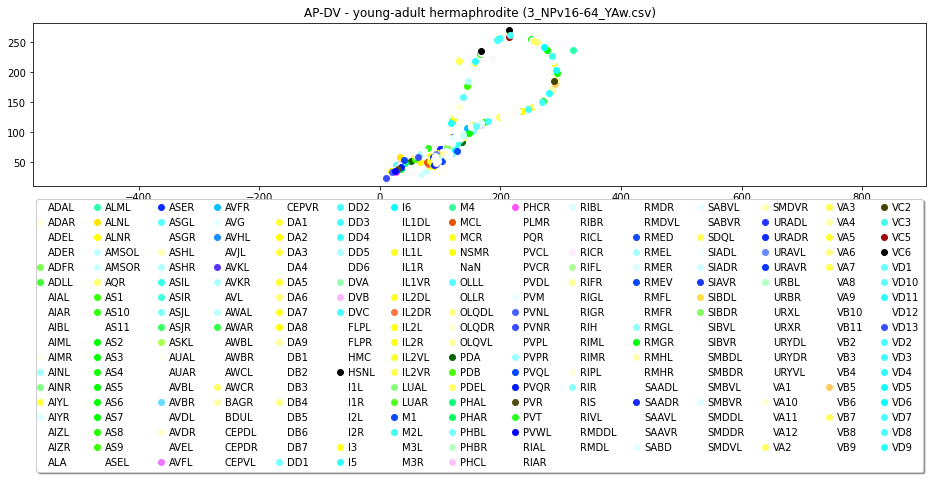

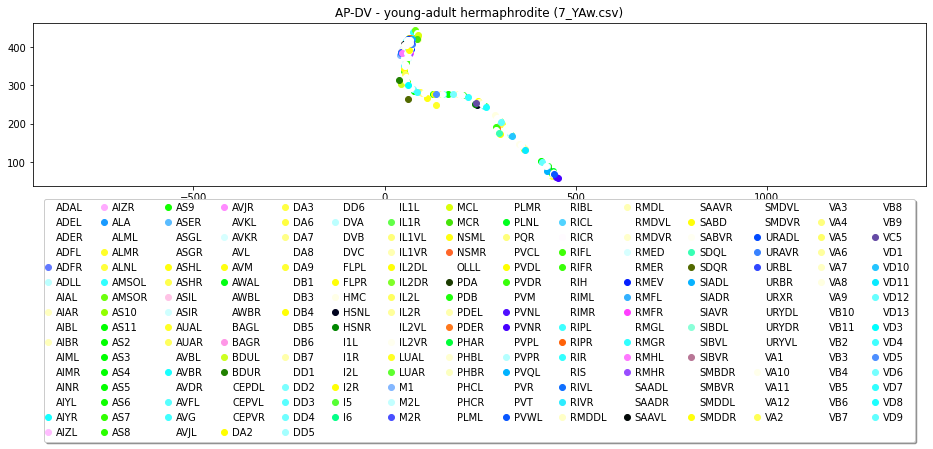

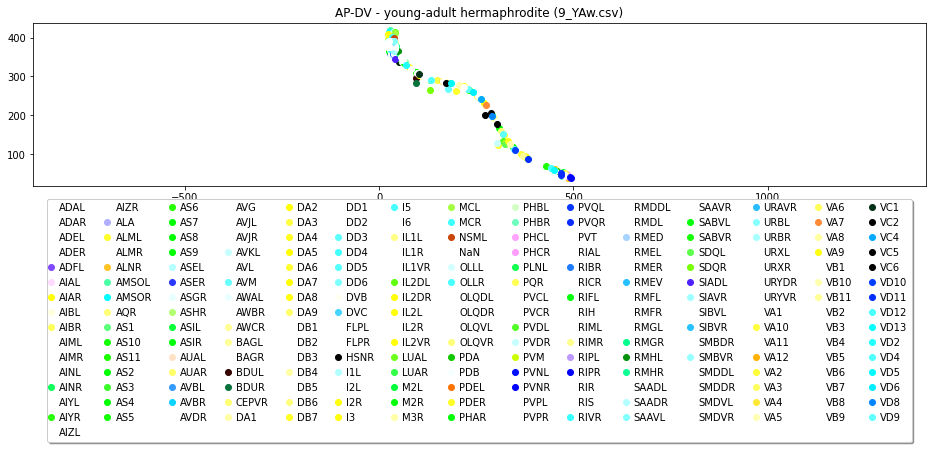

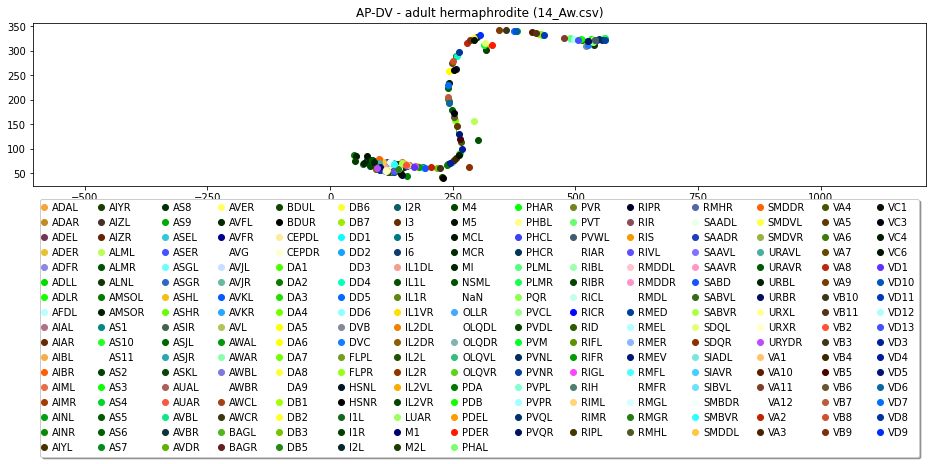

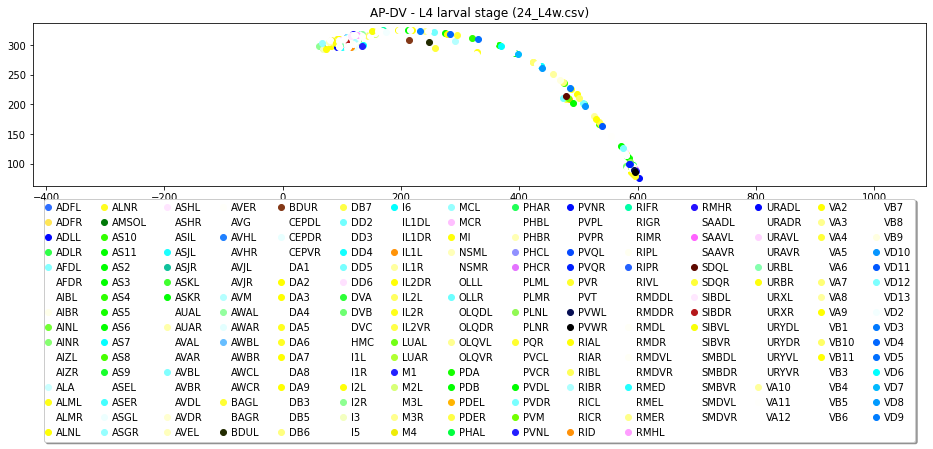

In [4]:
worms = {}
all_positions = {}
with open('data/WholeWorm/naming.txt') as f:
    lines = f.readlines()
    for l in lines:
        w = l.split('=')
        worms[w[0].strip()] = w[1].strip()
print(worms)

        
for ref in worms:
    filename = 'data/WholeWorm/Raw Unstraightened Individuals with colors/%s.csv'%ref
    positions = load_positions(filename)
    all_positions[ref] = positions
    generate_ap_dv_plot(positions, ref, worms[ref])
    

Loaded in 237 positions from data/WholeWorm/Straightened Individuals/1_YAw.csv
Loaded in 218 positions from data/WholeWorm/Straightened Individuals/2_AMw.csv
Loaded in 264 positions from data/WholeWorm/Straightened Individuals/3_NPv16-64_YAw.csv
Loaded in 231 positions from data/WholeWorm/Straightened Individuals/7_YAw.csv
Loaded in 226 positions from data/WholeWorm/Straightened Individuals/9_YAw.csv
Loaded in 248 positions from data/WholeWorm/Straightened Individuals/14_Aw.csv
Loaded in 237 positions from data/WholeWorm/Straightened Individuals/24_L4w.csv


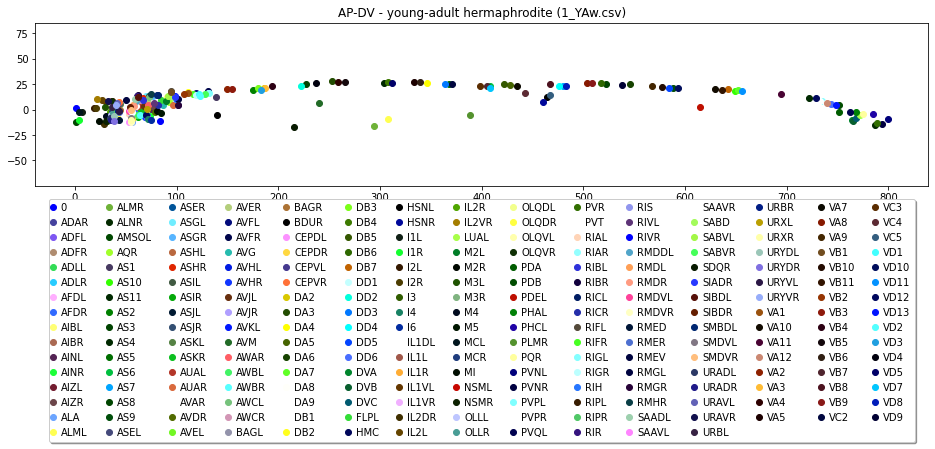

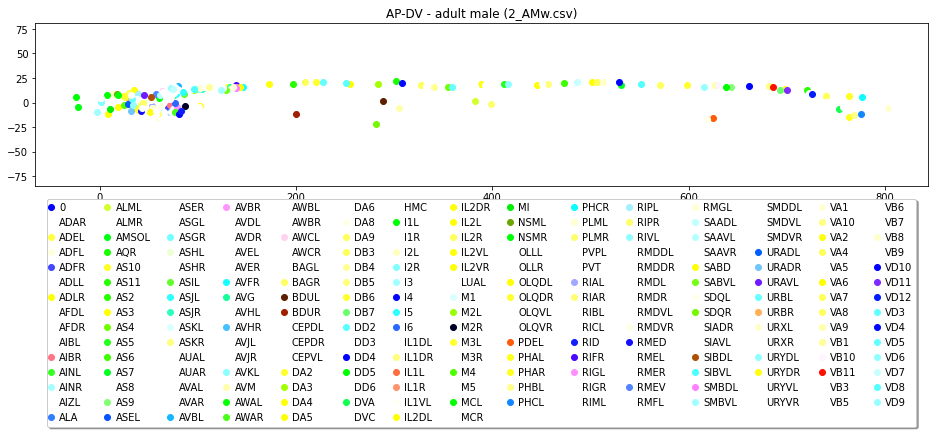

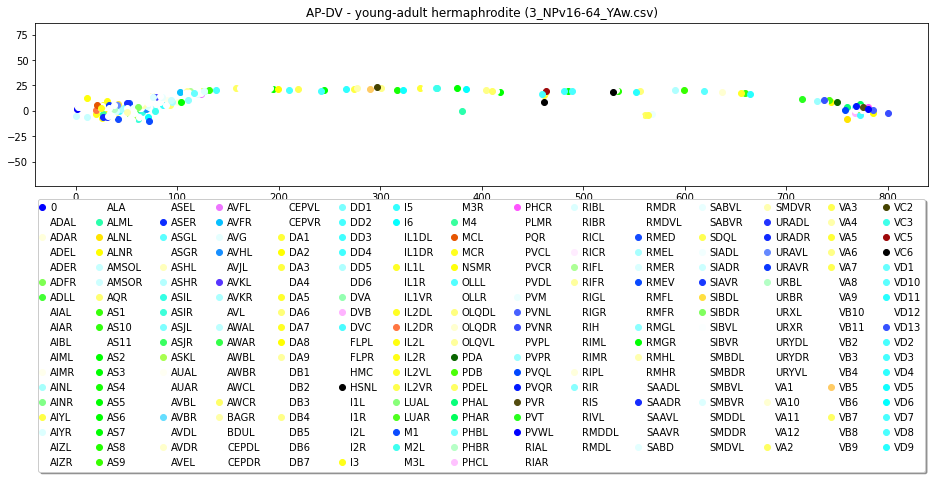

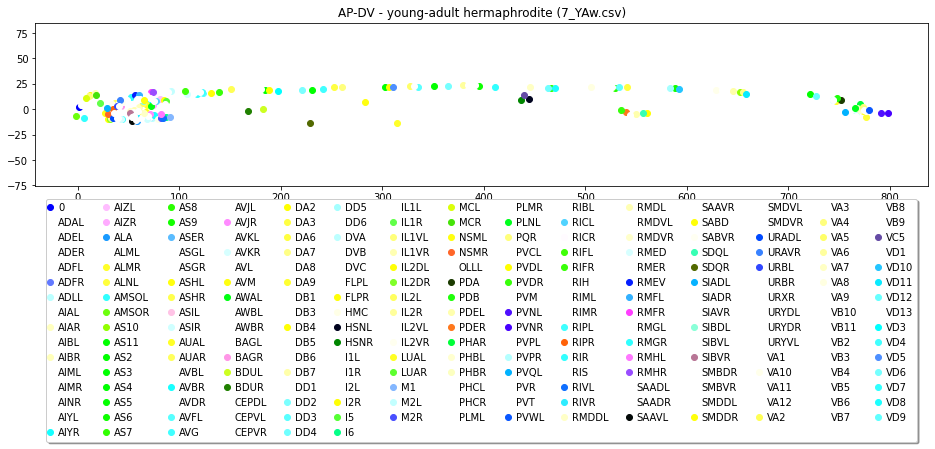

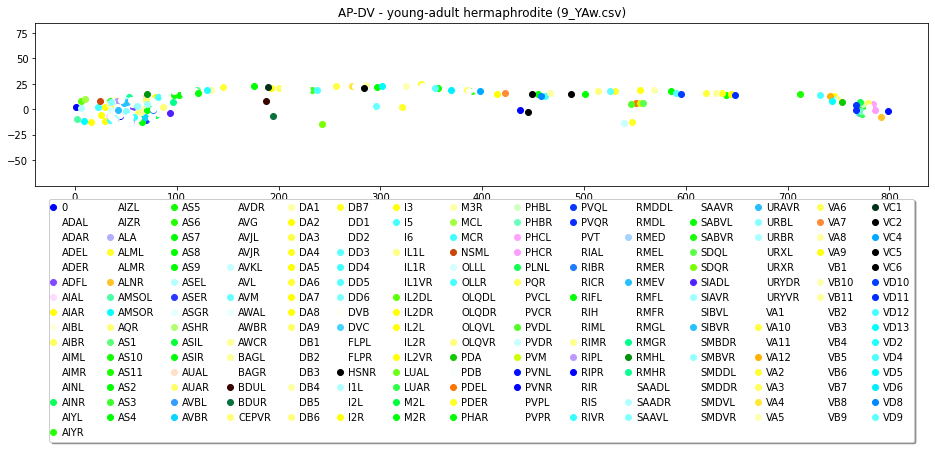

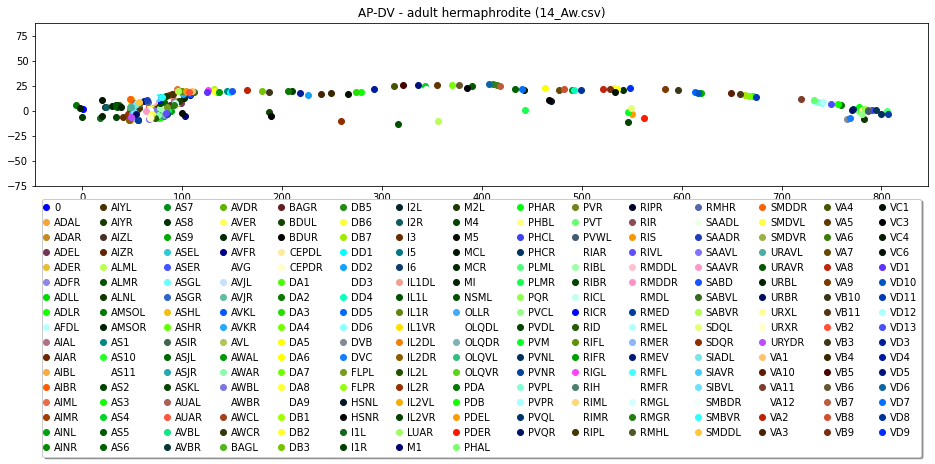

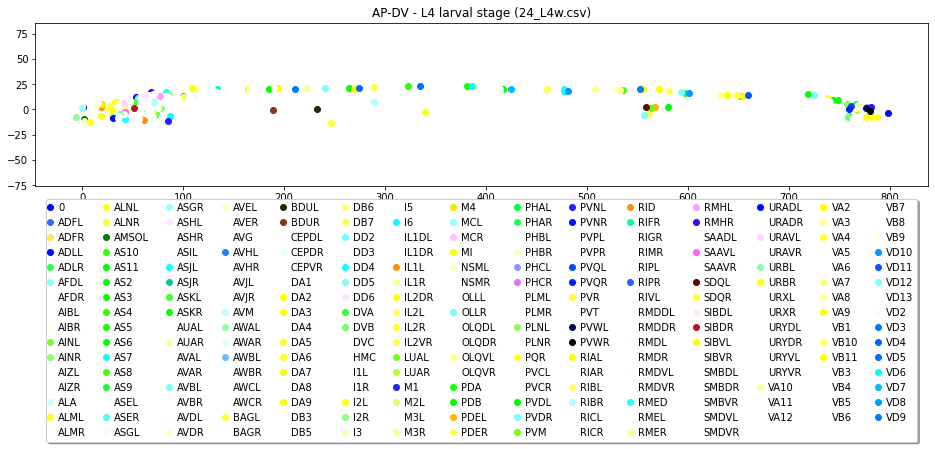

In [5]:
for ref in worms:
    filename = 'data/WholeWorm/Straightened Individuals/%s.csv'%ref
    positions = load_positions(filename)
    all_positions['%s_st'%ref] = positions
    generate_ap_dv_plot(positions, ref, worms[ref])

In [6]:
for ref in all_positions:
    print('Position set: %s, %i neurons'%(ref, len(all_positions[ref])))
    pos = all_positions[ref]
    for neuron in list(pos.keys())[:2]:
        print('   %s: (%s,%s,%s)'%(neuron, pos[neuron]['ap_position'], pos[neuron]['dv_position'], pos[neuron]['lr_position']))

Position set: 1_YAw, 238 neurons
   AMSOL: (42.371071,121.543249,15.041481)
   I1R: (47.492652,123.917271,6.302585)
Position set: 2_AMw, 218 neurons
   I1L: (35.685268,230.937255,14.30051)
   AMSOL: (38.588631,222.578927,15.321975)
Position set: 3_NPv16-64_YAw, 265 neurons
   PVNR: (10.395954,23.795457,13.279045)
   PLMR: (17.055521,24.835777,14.30051)
Position set: 7_YAw, 231 neurons
   BDUR: (38.688713,314.799742,9.193185)
   : (244.331767,258.243985,14.30051)
Position set: 9_YAw, 227 neurons
   SMDVR: (22.440422,376.77906,13.579045)
   IL2DR: (22.83297,396.911963,13.46925)
Position set: 14_Aw, 249 neurons
   AMSOL: (49.560387,87.794404,18.38637)
   I1R: (51.69673,75.964636,15.1142)
Position set: 24_L4w, 236 neurons
   I2R: (62.100805,298.503807,8.893185)
   MCL: (66.885523,303.809997,15.321975)
Position set: 1_YAw_st, 237 neurons
   0: (1.0,2.0,3.0)
   AMSOL: (1.5023074028808368,-12.32489989817713,6.1405547287577535)
Position set: 2_AMw_st, 218 neurons
   0: (1.0,2.0,3.0)
   I1L: (-

In [7]:
import neuroml
from pyneuroml import pynml

import neuroml.writers as writers

o = 200
o_st = 150

offset = {'1_YAw':(0,0,0),'1_YAw_st':(0,0,0)
         ,'2_AMw':(0,0,o),'2_AMw_st':(0,0,o_st)
         ,'3_NPv16-64_YAw':(0,0,o*2),'3_NPv16-64_YAw_st':(0,0,o_st*2)
         ,'7_YAw':(0,0,o*3),'7_YAw_st':(0,0,o_st*3)
         ,'9_YAw':(0,0,o*4),'9_YAw_st':(0,0,o_st*4)
         ,'14_Aw':(0,0,o*5),'14_Aw_st':(0,0,o_st*5)
         ,'24_L4w':(0,0,o*6),'24_L4w_st':(0,0,o_st*6)}

transform_x = {'1_YAw':1}
transform_y = {'1_YAw':1}

sets_to_include = offset.keys()
for s in sets_to_include:
    transform_x[s]=1
    transform_y[s]=1

prototype_neuron = 'GenericNeuronCell'
cell = neuroml.FitzHughNagumoCell(id=prototype_neuron, I=0.1)

nml_doc_all = neuroml.NeuroMLDocument(id="NeuroPAL_All")
nml_doc_all.fitz_hugh_nagumo_cells.append(cell)

net_all = neuroml.Network(id=nml_doc_all.id)
nml_doc_all.networks.append(net_all)

nml_doc_all_st = neuroml.NeuroMLDocument(id="NeuroPAL_All_straightened")
nml_doc_all_st.fitz_hugh_nagumo_cells.append(cell)

net_all_st = neuroml.Network(id=nml_doc_all_st.id)
nml_doc_all_st.networks.append(net_all_st)

for ref in sets_to_include:
    print(' - Adding positions for %s'%ref)
    ref_ = ref.replace(' ','_').replace('-','_')
    nml_doc = neuroml.NeuroMLDocument(id="NeuroPAL_%s"%ref_)
    nml_doc.fitz_hugh_nagumo_cells.append(cell)

    net = neuroml.Network(id=nml_doc.id)
    nml_doc.networks.append(net)

    for neuron in all_positions[ref]:
        
        if not neuron=='0':

            # Add in file for individual part
            pop = neuroml.Population(id="pop_%s"%neuron, component=prototype_neuron, type="populationList")
            net.populations.append(pop)
            pos = all_positions[ref]
            c = pos[neuron]['color']
            #print('Adding neuron %s, color: %s'%(neuron,c))
            pop.properties.append(neuroml.Property(tag="color", value='%f %f %f'%(c[0],c[1],c[2])))
            pop.properties.append(neuroml.Property(tag="radius", value=2))

            inst = neuroml.Instance(id="0")
            pop.instances.append(inst)

            inst.location = neuroml.Location(x=pos[neuron]['ap_position'], 
                                     y=pos[neuron]['dv_position'], 
                                     z=pos[neuron]['lr_position'])
        
            
            # Add in file for all parts
            pop = neuroml.Population(id="%s_%s"%(neuron,ref_), component=prototype_neuron, type="populationList")
            
            if '_st' in ref:
                net_all_st.populations.append(pop)
            else:
                net_all.populations.append(pop)
            
            c = pos[neuron]['color']
            pop.properties.append(neuroml.Property(tag="color", value='%f %f %f'%(c[0],c[1],c[2])))
            pop.properties.append(neuroml.Property(tag="radius", value=2))

            inst = neuroml.Instance(id="0")
            pop.instances.append(inst)
            

            inst.location = neuroml.Location(
                               x=transform_x[ref]*pos[neuron]['ap_position']+offset[ref][0], 
                               y=transform_y[ref]*pos[neuron]['dv_position']+offset[ref][1], 
                               z=pos[neuron]['lr_position']+offset[ref][2])
            
            


    ###### Write the NeuroML network file ######   
    nml_file = 'NeuroML2/%s.net.nml'%net.id
    writers.NeuroMLWriter.write(nml_doc, nml_file)
    print("Written network file to: "+nml_file)

    ###### Validate the NeuroML ######    
    from neuroml.utils import validate_neuroml2
    validate_neuroml2(nml_file)


    ###### Convert NeuroML network to png and display ######    
    #pynml.nml2_to_svg(nml_file)
        
            

###### Write the NeuroML network file with all parts ######   
nml_file_all = 'NeuroML2/%s.net.nml'%net_all.id
writers.NeuroMLWriter.write(nml_doc_all, nml_file_all)
print("Written network file to: "+nml_file_all)

###### Validate the NeuroML ######    
from neuroml.utils import validate_neuroml2
validate_neuroml2(nml_file_all)

###### Convert NeuroML network to svg ######    
#pynml.nml2_to_svg(nml_file_all) # uncomment this line to regenerate, commented out as quite verbose


###### Write the NeuroML network file with all parts - straightened ######   
nml_file_all_st = 'NeuroML2/%s.net.nml'%net_all_st.id
writers.NeuroMLWriter.write(nml_doc_all_st, nml_file_all_st)
print("Written network file to: "+nml_file_all_st)

###### Validate the NeuroML ######    
from neuroml.utils import validate_neuroml2
validate_neuroml2(nml_file_all_st)


###### Convert NeuroML network to svg ######    
#pynml.nml2_to_svg(nml_file_all_st) # uncomment this line to regenerate, commented out as quite verbose
        
            

 - Adding positions for 1_YAw
Written network file to: NeuroML2/NeuroPAL_1_YAw.net.nml
Validating NeuroML2/NeuroPAL_1_YAw.net.nml against /Users/padraig/anaconda/envs/py37/lib/python3.7/site-packages/libNeuroML-0.4.0-py3.7.egg/neuroml/nml/NeuroML_v2.3.xsd
It's valid!
 - Adding positions for 1_YAw_st
Written network file to: NeuroML2/NeuroPAL_1_YAw_st.net.nml
Validating NeuroML2/NeuroPAL_1_YAw_st.net.nml against /Users/padraig/anaconda/envs/py37/lib/python3.7/site-packages/libNeuroML-0.4.0-py3.7.egg/neuroml/nml/NeuroML_v2.3.xsd
It's valid!
 - Adding positions for 2_AMw
Written network file to: NeuroML2/NeuroPAL_2_AMw.net.nml
Validating NeuroML2/NeuroPAL_2_AMw.net.nml against /Users/padraig/anaconda/envs/py37/lib/python3.7/site-packages/libNeuroML-0.4.0-py3.7.egg/neuroml/nml/NeuroML_v2.3.xsd
It's valid!
 - Adding positions for 2_AMw_st
Written network file to: NeuroML2/NeuroPAL_2_AMw_st.net.nml
Validating NeuroML2/NeuroPAL_2_AMw_st.net.nml against /Users/padraig/anaconda/envs/py37/lib/py

# Images generated from NeuroML

### All cells - original

![svg from neuroml](NeuroML2/NeuroPAL_All.net.svg)

### All straightened

![svg from neuroml](NeuroML2/NeuroPAL_All_straightened.net.svg)